In [1]:
import numpy as np 
import pandas as pd
import torch
import os
import time
import random
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
from pathlib import Path 
from sklearn.preprocessing import LabelEncoder

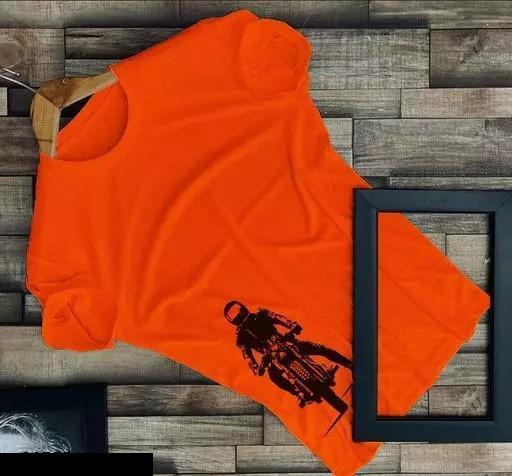

In [2]:
folder_train = "/kaggle/input/visual-taxonomy/train_images"
folder_test = "/kaggle/input/visual-taxonomy/test_images"
Image.open(f"{folder_train}/000000.jpg")

In [3]:
def load_images_from_folder(folder, num_images):
    image_list = []
    folder = Path(folder)
    image_files = [f for f in folder.iterdir() if f.suffix in ['.jpg', '.png', '.jpeg']]
    
    # Pick random images to load (if the folder has more than num_images)
    selected_files = np.random.choice(image_files, num_images, replace=False)
#     selected_files = 
    
    for img_file in selected_files:
        img = Image.open(img_file)
        image_list.append((img, img_file.name))
    
    return image_list


def plot_images(images):
    images.sort(key = lambda x : x[1])
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, (img, img_name) in zip(axes, images):
        ax.imshow(img)
        ax.set_title(img_name)
        ax.axis('off')
    plt.show()

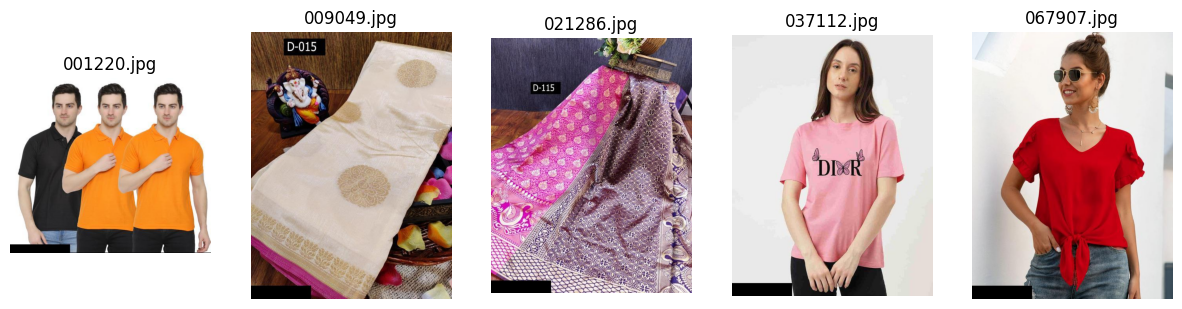

In [4]:
# Load 5 images for initial analysis
images = load_images_from_folder(folder_train, num_images=5)
plot_images(images)

In [5]:
# Attributes of the above image
prod_id_list = [int(i.strip('.jpg')) for (_,i) in images]
train_attribute = pd.read_csv('/kaggle/input/visual-taxonomy/train.csv')
train_attribute.query(f"id in {prod_id_list}")

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10
1220,1220,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
8884,9049,Sarees,10,same as saree,zari,small border,cream,party,NaN,same as saree,zari woven,default,no
21121,21286,Sarees,10,same as saree,woven design,NaN,multicolor,party,jacquard,woven design,zari woven,applique,no
36946,37112,Women Tshirts,8,pink,loose,long,printed,typography,short sleeves,regular sleeves,NaN,NaN,NaN
67741,67907,Women Tops & Tunics,10,red,regular,regular,v-neck,casual,solid,solid,short sleeves,default,waist tie-ups


In [6]:
train_attribute = train_attribute.fillna("my_dummy_value")
category_attribute = pd.read_parquet('/kaggle/input/visual-taxonomy/category_attributes.parquet')
category_attribute

,Category,No_of_attribute,Attribute_list
0,Men Tshirts,5,"[color, neck, pattern, print_or_pattern_type, ..."
1,Sarees,10,"[blouse_pattern, border, border_width, color, ..."
2,Kurtis,9,"[color, fit_shape, length, occasion, ornamenta..."
3,Women Tshirts,8,"[color, fit_shape, length, pattern, print_or_p..."
4,Women Tops & Tunics,10,"[color, fit_shape, length, neck_collar, ocassi..."


In [7]:
def visualise_category(category):
    attribute_list = category_attribute.query(f'Category == "{category}"').Attribute_list
    col_name = list((attribute_list).to_list()[0])
    col_dict = {f'attr_{i+1}':j for (i,j) in enumerate(col_name)}
    drop_col = [f'attr_{i+1}' for i in range(len(col_name),10)]
    data = (train_attribute
            .query(f'Category == "{category}"')
            .drop(['id', 'Category', 'len']+drop_col, axis=1)
            .rename(columns = col_dict)
           )
    # Set the number of columns and rows for the grid
    n_cols = 5  # 2 columns in the grid
    n_rows = 2  # 5 rows to accommodate 10 attributes

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
    axes = axes.ravel()  # Flatten the 2D array of axes into 1D to iterate easily
    # Plot pie charts for each categorical column
    for i, col in enumerate(data.columns):
        # Get the value counts of the column
        counts = data[col].value_counts()

        # Plot the pie chart
        axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
        axes[i].set_title(f'Distribution of {col}')
    # Hide the remaining empty subplots
    for j in range(len(col_name), 10):
        fig.delaxes(axes[j])  # Remove the extra subplot
        
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()
    return data

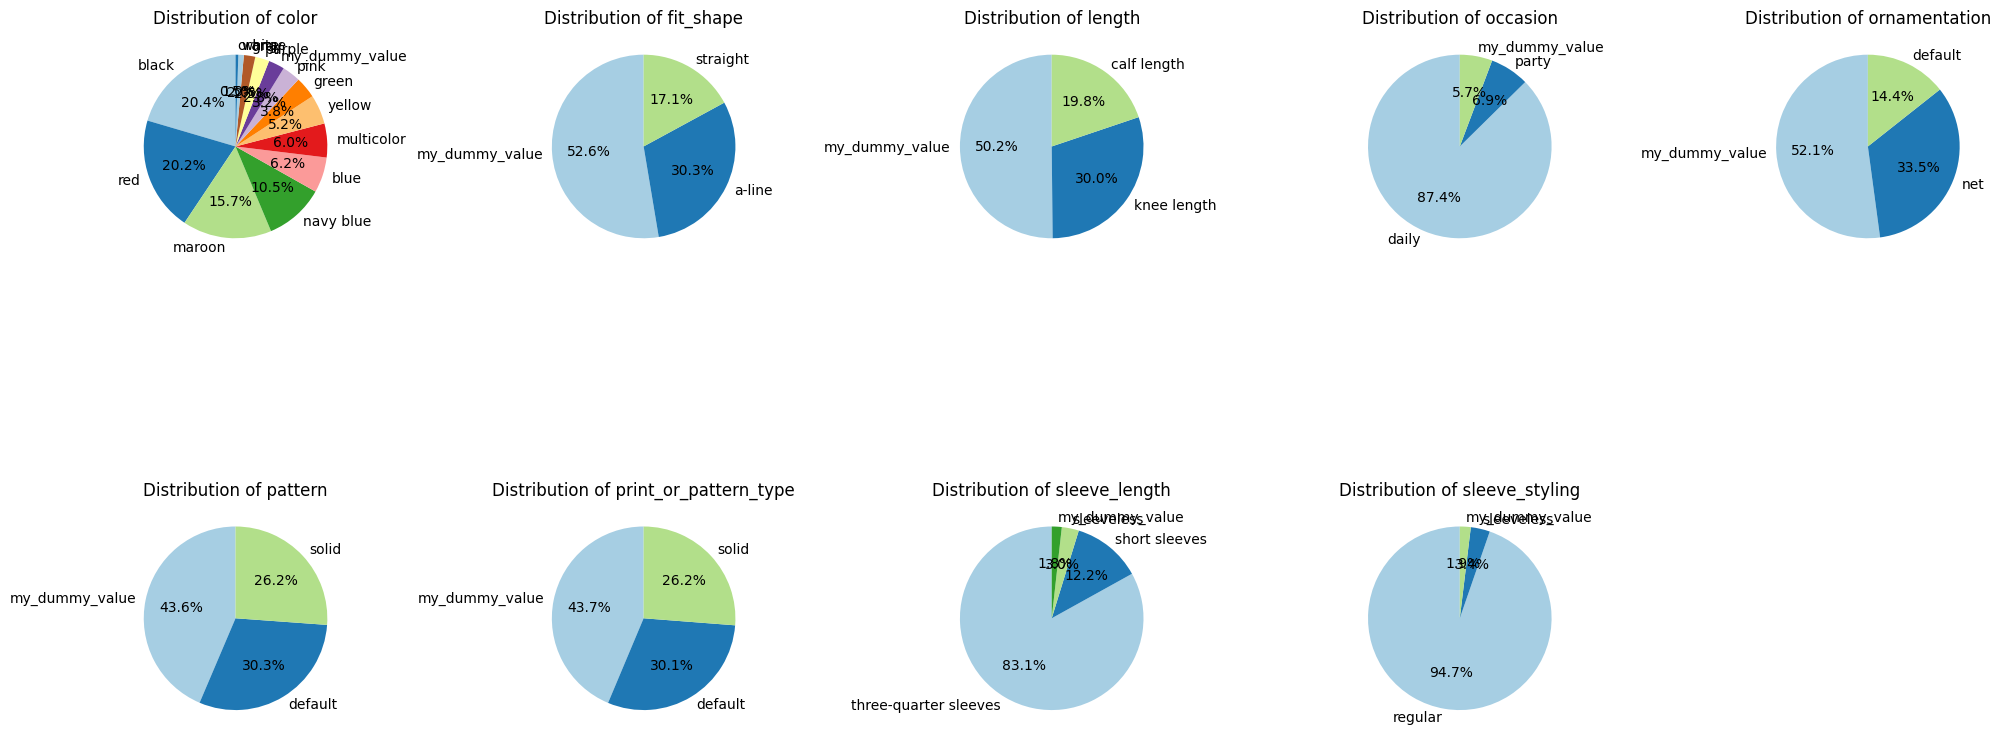

In [8]:
data_kurtis = visualise_category(category = "Kurtis")

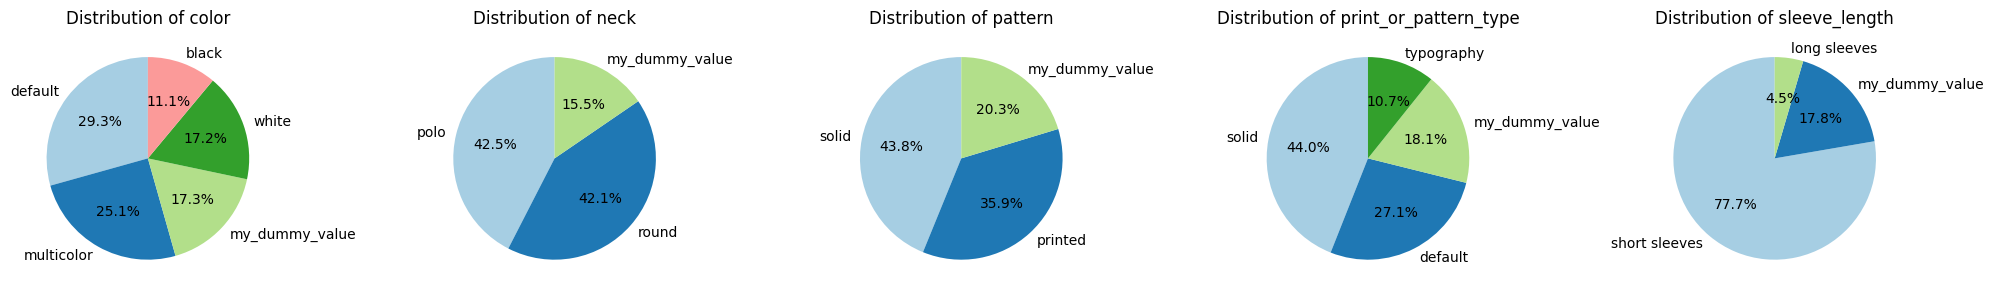

In [9]:
data_men_tshirt = visualise_category(category = "Men Tshirts")

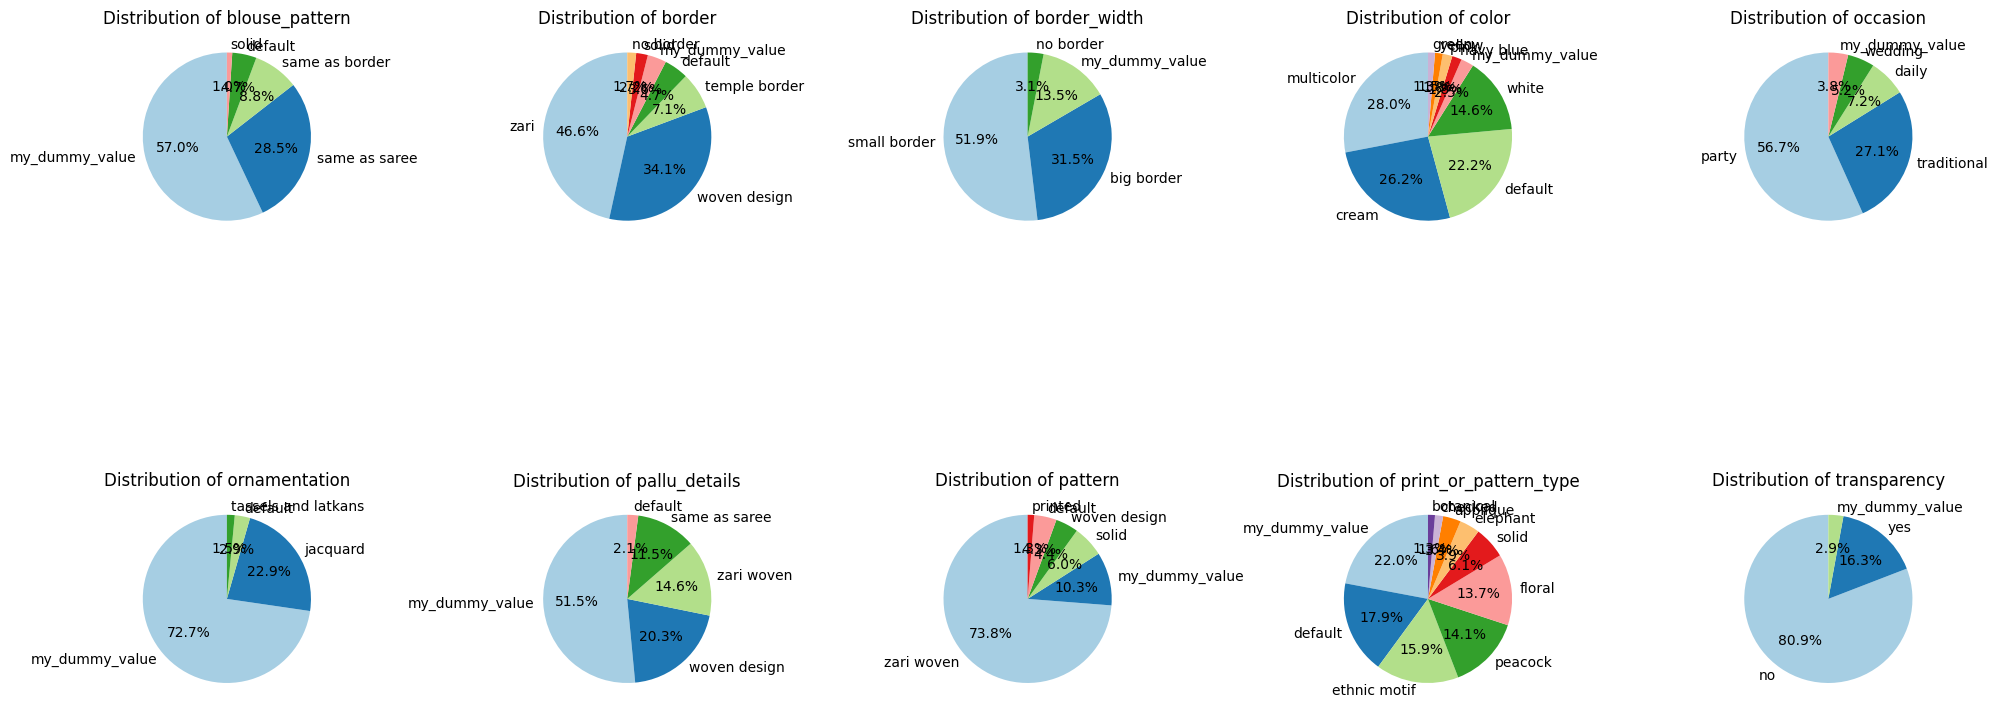

In [10]:
data_sarees = visualise_category(category = "Sarees")

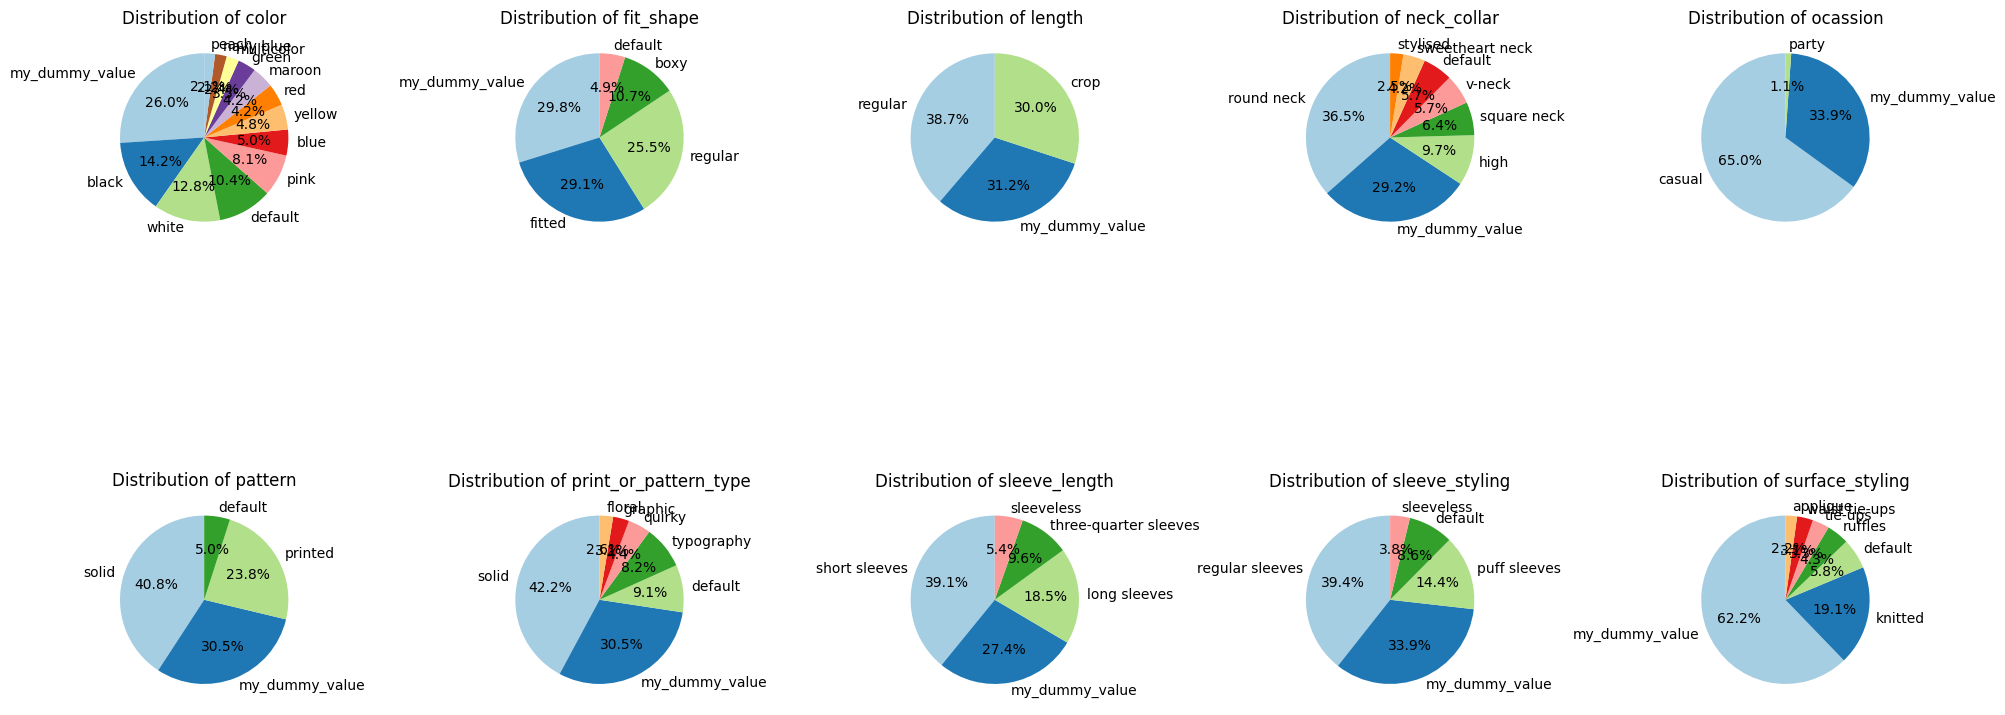

In [11]:
data_women_tops = visualise_category(category = "Women Tops & Tunics")